In [3]:
import cv2
import numpy as np
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt



def preprocess_image_db(img):
    coords = np.column_stack(np.where(img > 0))

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped_img = img[x_min:x_max+1, y_min:y_max+1]
    cropped_img = np.array(cropped_img, dtype=np.uint8)

    padded_img = cv2.copyMakeBorder(cropped_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

    resized_img = cv2.resize(padded_img, (28, 28))

    return resized_img.flatten()


def preprocess_dataset(df):
    df_processed = df.copy()
    for i in range(len(df)):
        df_processed.iloc[i, 1:] = preprocess_image_db(df.iloc[i, 1:].values.reshape(28, 28)).flatten()

    return df_processed

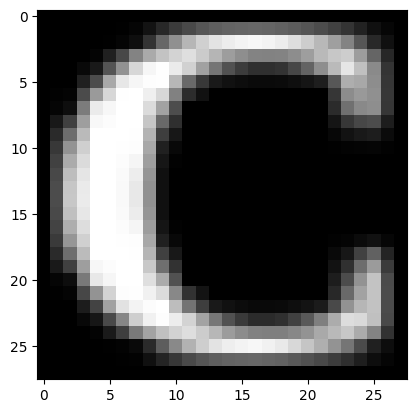

In [ ]:
df = pd.read_csv("/content/uaset.csv")

img = df.iloc[1][1:].values.reshape([28, 28])


processed_image = preprocess_image_db(img)

plt.imshow(processed_image.reshape([28, 28]), cmap='gray') 
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import cv2
from skimage import measure

df = pd.read_csv("/content/uaset.csv")



processed_images = []

for index, row in df.iterrows():
    try:
        image = row[1:].values.reshape([28, 28])
        processed_image = preprocess_image_db(image)
        processed_images.append(processed_image.flatten())
    except:
        print(index)

processed_df = pd.DataFrame(processed_images, columns=df.columns[1:])
processed_df.insert(0, 'label', df['label'])

processed_df.to_csv("processed_uaset.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9966 entries, 0 to 9965
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 59.7 MB
None


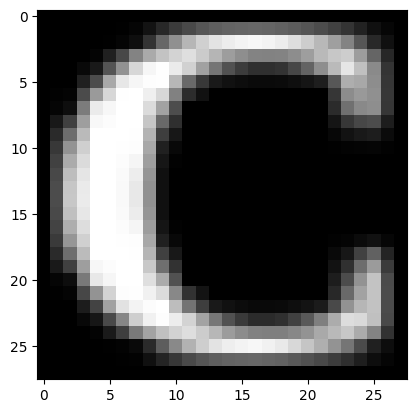

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/processed_uaset.csv")
print(df.info())

df_processed = preprocess_dataset(df)

k = 0 
plt.imshow(df_processed.iloc[1][1:].values.reshape([28, 28]), cmap='gray') 
plt.show()

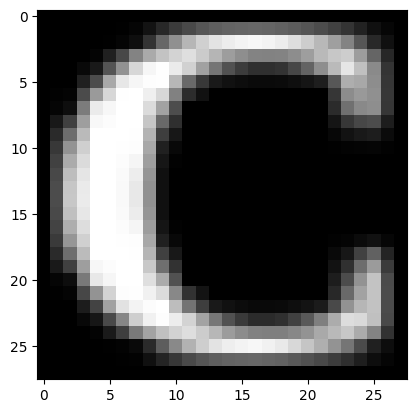

In [ ]:
plt.imshow(df.iloc[1][1:].values.reshape([28, 28]), cmap='gray') 
plt.show()

## Загрузка и подготовка данных 

In [4]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

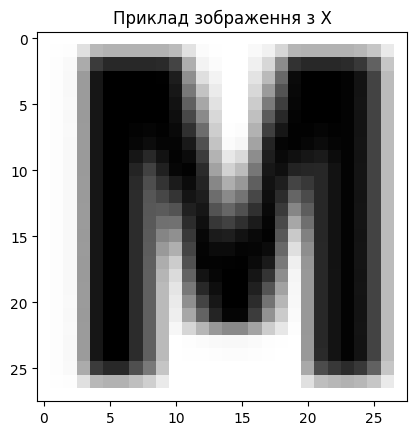

In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/processed_uaset.csv")

X = df[df.columns[1:]]
y = df['label']

X = X / 255.0

X = 1 - X

plt.imshow(X.values[0].reshape(28, 28), cmap='gray')
plt.title('Приклад зображення з X')
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

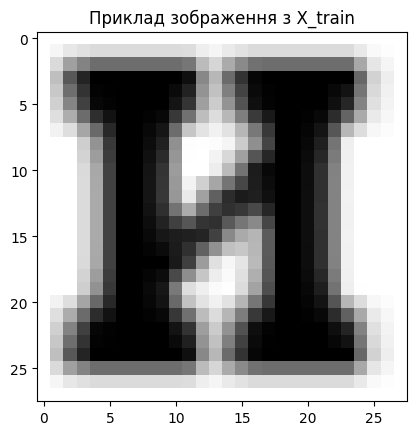

In [6]:

plt.imshow(X_train[20].reshape(28, 28), cmap='gray')
plt.title('Приклад зображення з X_train')
plt.show()

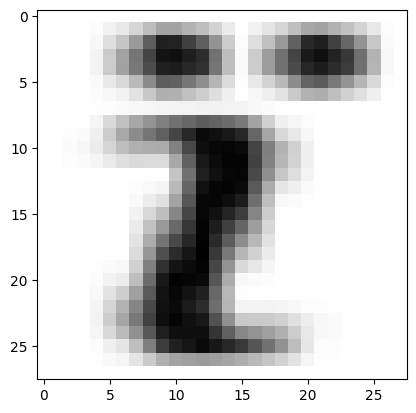

In [ ]:
reshaped_img = X_train[10].reshape( (28, 28))

plt.imshow(reshaped_img, cmap='gray') 
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

class ImageDataGeneratorWithNoise(ImageDataGenerator):
    def __init__(self, noise_stddev=0.1, **kwargs):
        super().__init__(**kwargs)
        self.noise_stddev = noise_stddev

    def random_transform(self, x):
        x = super().random_transform(x)
        noise = np.random.normal(scale=self.noise_stddev, size=x.shape)
        return np.clip(x + noise * 0.2, 0., 1.) 


datagen = ImageDataGeneratorWithNoise(
    zoom_range=0.1,
    height_shift_range=0.1,

    noise_stddev=0.1 
)

datagen.fit(X_train)



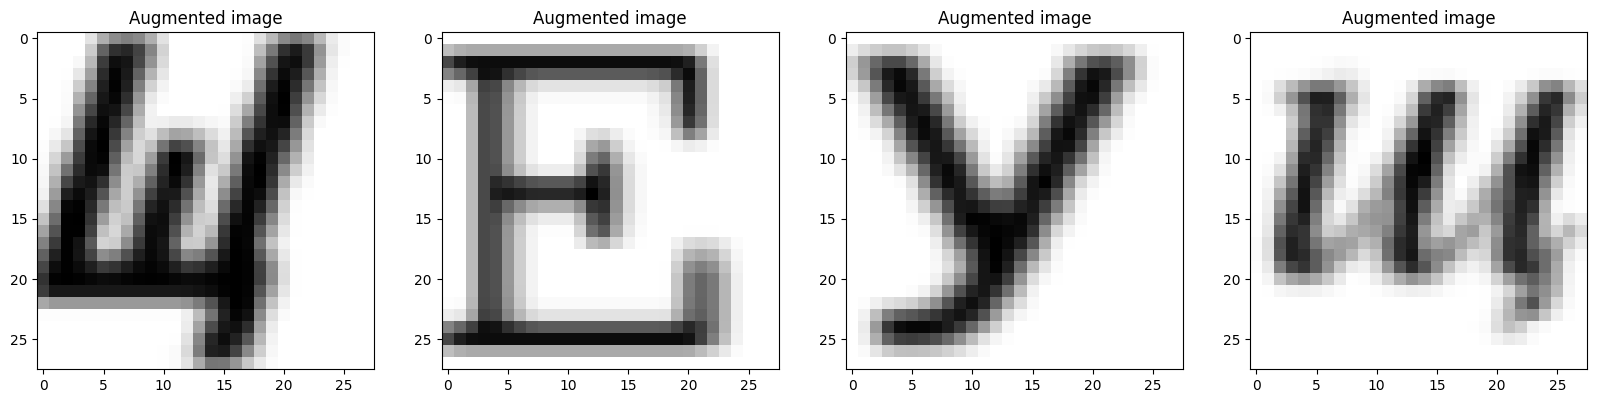

In [ ]:
import matplotlib.pyplot as plt

# Отримуємо один випадковий набір зображень
images, labels = next(datagen.flow(X_train, y_train, batch_size=4))

# Візуалізуємо аугментовані зображення
fig, axes = plt.subplots(1, 4, figsize=(20,10))

for i in range(4):
    axes[i].imshow(images[i].squeeze(), cmap='gray')  
    axes[i].set_title('Augmented image')
plt.show()


## підбір гіперпараметрів

In [ ]:
pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense
import keras


input_shape=(28,28,1)
num_classes=y_train.shape[1]
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
    model = Sequential()

    model.add(Conv2D(input_shape=input_shape, 
                     activation='relu', 
                     filters=hp.Int('conv_1_filters', min_value=64, max_value=128, step=16), 
                     kernel_size=hp.Choice('conv_1_kernel_size', values = [3, 5]), 
                     padding='same'))
    model.add(Conv2D(activation='relu', 
                     filters=hp.Int('conv_2_filters', min_value=32, max_value=64, step=16), 
                     kernel_size=hp.Choice('conv_2_kernel_size', values = [3, 5]), 
                     padding='same'))
    model.add(Conv2D( activation='relu', 
                      filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=16), 
                      kernel_size=hp.Choice('conv_3_kernel_size', values = [3, 5]),  
                      padding='same', 
                      strides=2))
    model.add(Dropout(0.4))

    model.add(Conv2D(activation='relu', 
                     filters=hp.Int('conv_4_filters', min_value=64, max_value=128, step=16), 
                     kernel_size=hp.Choice('conv_4_kernel_size', values = [3, 5]), 
                     padding='same'))
    model.add(Conv2D(activation='relu', 
                     filters=hp.Int('conv_5_filters', min_value=64, max_value=128, step=16), 
                     kernel_size=hp.Choice('conv_5_kernel_size', values = [3, 5]), 
                     padding='same'))
    model.add(Conv2D(activation='relu', 
                     filters=hp.Int('conv_6_filters', min_value=64, max_value=128, step=16), 
                     kernel_size=hp.Choice('conv_6_kernel_size', values = [3, 5]),  
                     padding='same', 
                     strides=2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='Hypertuning',
    overwrite=True)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=15,
             validation_data=(X_test, y_test))

tuner.results_summary()



Trial 5 Complete [00h 02m 59s]
val_accuracy: 0.015379472014804682

Best val_accuracy So Far: 0.9306252201398214
Total elapsed time: 00h 15m 33s
Results summary
Results in output/Hypertuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
conv_1_filters: 128
conv_1_kernel_size: 3
conv_2_filters: 32
conv_2_kernel_size: 5
conv_3_filters: 112
conv_3_kernel_size: 3
conv_4_filters: 128
conv_4_kernel_size: 5
conv_5_filters: 128
conv_5_kernel_size: 3
conv_6_filters: 112
conv_6_kernel_size: 5
learning_rate: 0.0001
Score: 0.9306252201398214

Trial 1 summary
Hyperparameters:
conv_1_filters: 112
conv_1_kernel_size: 5
conv_2_filters: 64
conv_2_kernel_size: 5
conv_3_filters: 48
conv_3_kernel_size: 5
conv_4_filters: 112
conv_4_kernel_size: 5
conv_5_filters: 128
conv_5_kernel_size: 5
conv_6_filters: 96
conv_6_kernel_size: 3
learning_rate: 0.0001
Score: 0.9224339524904887

Trial 4 summary
Hyperparameters:
conv_1_filters: 128
conv_1_kernel_size: 5

## Навчання моделі

In [ ]:
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop

class CharacterRecognizer:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()


    def _build_model(self):
        model = Sequential()

        model.add(Conv2D(input_shape=self.input_shape, activation='relu', filters=128, kernel_size=3, padding='same'))
        model.add(Conv2D(activation='relu', filters=32,kernel_size=5, padding='same'))
        model.add(Conv2D( activation='relu', filters=112,kernel_size=3,  padding='same'))
        model.add(Dropout(0.4))

        model.add(Conv2D(activation='relu', filters=128,kernel_size=5,padding='same',strides=2))
        model.add(Conv2D(activation='relu', filters=128, kernel_size=3,padding='same',strides=3))
            
        model.add(Conv2D(activation='relu',filters=112,kernel_size=5, padding='same'))
            
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(units=128, activation='relu'))
        model.add(Dropout(0.4))

        model.add(Dense(units=self.num_classes, activation='softmax'))

        
        return model

    def compile(self):
        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),

            metrics=["accuracy"]
        )
    def fit(self, X_train, y_train, X_test, y_test, epochs, batch_size=128):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        # self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

        # для аугментированных данных 
        self.model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            epochs=epochs)

    def save(self, path):
        self.model.save(path)

# Ініціалізація та навчання моделі
recognizer = CharacterRecognizer(input_shape=(28,28,1), num_classes=y_train.shape[1])
recognizer.compile()
recognizer.fit(X_train, y_train, X_test, y_test, epochs=15)
# recognizer.save('character_recognition_model2.h5')
recognizer.save('best_model.h5')

Epoch 1/15
63/63 [==============================] - 5s 59ms/step - loss: 4.1783 - accuracy: 0.0226 - val_loss: 4.0713 - val_accuracy: 0.0812
Epoch 2/15
63/63 [==============================] - 4s 69ms/step - loss: 3.6172 - accuracy: 0.1213 - val_loss: 2.1579 - val_accuracy: 0.4473
Epoch 3/15
63/63 [==============================] - 3s 52ms/step - loss: 2.5986 - accuracy: 0.2988 - val_loss: 1.2715 - val_accuracy: 0.6194
Epoch 4/15
63/63 [==============================] - 3s 51ms/step - loss: 2.0425 - accuracy: 0.4076 - val_loss: 0.9590 - val_accuracy: 0.6650
Epoch 5/15
63/63 [==============================] - 3s 53ms/step - loss: 1.7297 - accuracy: 0.4748 - val_loss: 0.8271 - val_accuracy: 0.7121
Epoch 6/15
63/63 [==============================] - 3s 53ms/step - loss: 1.5422 - accuracy: 0.5199 - val_loss: 0.7226 - val_accuracy: 0.7232
Epoch 7/15
63/63 [==============================] - 4s 57ms/step - loss: 1.3656 - accuracy: 0.5631 - val_loss: 0.6840 - val_accuracy: 0.7312
Epoch 8/15
63